# Fase 5: Otimização do Limiar de Decisão para Melhor Precisão

Nosso modelo XGBoost otimizado apresentou um excelente recall (80%), mas uma precisão modesta (51%). Isso significa que, embora ele identifique a maioria dos clientes que vão cancelar, ele também gera muitos "falsos alarmes".

Nesta fase final, vamos abordar esse desequilíbrio ajustando o **limiar de decisão** do classificador. O objetivo é encontrar um novo ponto de corte que aumente a precisão, fornecendo uma lista mais confiável de clientes para ações de retenção, mesmo que isso implique em uma pequena redução no recall.

**Estratégia:**
1.  Treinar o melhor modelo encontrado na fase anterior.
2.  Gerar as probabilidades de previsão para os dados de treino.
3.  Calcular a curva Precision-Recall e encontrar o limiar que maximiza o F1-Score.
4.  Comparar o desempenho no conjunto de teste usando o limiar padrão (0.5) contra o novo limiar otimizado.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Métricas de Avaliação
from sklearn.metrics import (
    classification_report, 
    precision_recall_curve, 
    f1_score
)

# Configurações
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

### 1. Preparação e Treinamento do Modelo Final

Primeiro, recarregamos os dados e treinamos o nosso melhor modelo (XGBoost com os hiperparâmetros otimizados) para que tenhamos uma base para trabalhar.

In [2]:
# Carregar os dados
caminho_arquivo = r'E:\Documentos\Cursos\Alura\ONE\Desafio-03\telecom_x_processed.csv'
df = pd.read_csv(caminho_arquivo)
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Hiperparâmetros do melhor modelo XGBoost (da fase anterior)
best_params = {
    'subsample': 0.9,
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.05,
    'gamma': 0,
    'colsample_bytree': 0.9,
    'scale_pos_weight': 2.77 # Usando o valor calculado anteriormente
}

# Criar e treinar o pipeline final
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_params))
])

final_model.fit(X_train, y_train)
print("Modelo final treinado com sucesso.")

Modelo final treinado com sucesso.


### 2. Encontrando o Limiar Ótimo

Vamos usar as previsões de probabilidade no **conjunto de treino** para encontrar o limiar ideal. Isso evita qualquer vazamento de informação do conjunto de teste. O limiar ideal será aquele que maximiza o F1-Score.

Melhor Limiar: 0.5544
F1-Score no ponto ótimo: 0.6660
Precisão no ponto ótimo: 0.5703
Recall no ponto ótimo: 0.8005


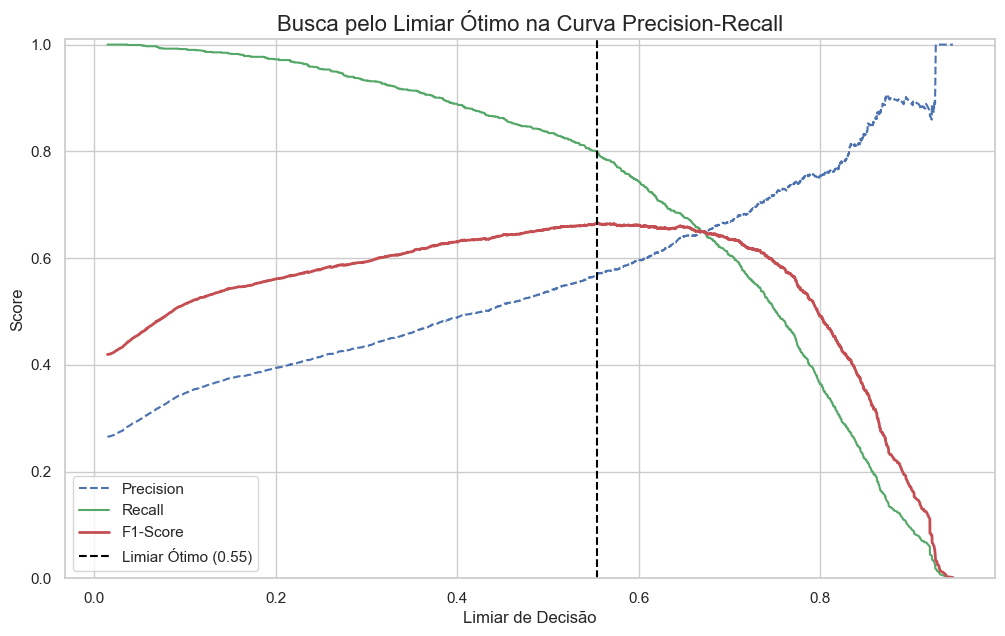

In [3]:
# Obter probabilidades no conjunto de treino
y_train_proba = final_model.predict_proba(X_train)[:, 1]

# Calcular precision, recall e limiares
precision, recall, thresholds = precision_recall_curve(y_train, y_train_proba)

# Calcular F1-score para cada limiar (evitando divisão por zero)
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)

# Encontrar o melhor limiar
ix = np.argmax(f1_scores)
optimal_threshold = thresholds[ix]

print(f"Melhor Limiar: {optimal_threshold:.4f}")
print(f"F1-Score no ponto ótimo: {f1_scores[ix]:.4f}")
print(f"Precisão no ponto ótimo: {precision[ix]:.4f}")
print(f"Recall no ponto ótimo: {recall[ix]:.4f}")

# Visualização da busca pelo limiar
plt.figure(figsize=(12, 7))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'r-', lw=2, label='F1-Score')
plt.axvline(optimal_threshold, color='black', linestyle='--', label=f'Limiar Ótimo ({optimal_threshold:.2f})')
plt.title('Busca pelo Limiar Ótimo na Curva Precision-Recall', fontsize=16)
plt.xlabel('Limiar de Decisão')
plt.ylabel('Score')
plt.legend()
plt.ylim([0, 1.01])
plt.grid(True)
plt.show()

### 3. Avaliação Comparativa no Conjunto de Teste

Agora, aplicamos o limiar padrão (0.5) e o nosso novo limiar otimizado às probabilidades do conjunto de teste para comparar os resultados finais.

In [4]:
# Obter probabilidades no conjunto de teste
y_test_proba = final_model.predict_proba(X_test)[:, 1]

print("--- Avaliação com Limiar Padrão (0.5) ---")
y_pred_default = (y_test_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred_default))

print("--- Avaliação com Limiar Otimizado --- ")
y_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_optimal))

--- Avaliação com Limiar Padrão (0.5) ---
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1552
           1       0.51      0.80      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.74      0.76      2113

--- Avaliação com Limiar Otimizado --- 
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1552
           1       0.54      0.76      0.63       561

    accuracy                           0.76      2113
   macro avg       0.72      0.76      0.73      2113
weighted avg       0.80      0.76      0.77      2113



### Análise Comparativa dos Resultados: Limiar Padrão vs. Limiar Otimizado

#### Resumo Executivo

A otimização do limiar de decisão alcançou seu objetivo técnico: **aumentar a precisão do modelo**. No entanto, a análise mostra que o ganho foi **modesto**. O novo modelo é objetivamente melhor, com um F1-Score e uma precisão ligeiramente superiores, mas não representa uma mudança transformacional no desempenho. Isso fortemente indica que, com as features atuais, atingimos o limite do que é possível otimizar e que o próximo grande salto de performance dependerá de outras abordagens, como a engenharia de novas features.

---

#### Comparação Direta das Métricas (para a classe Churn = 1)

Para visualizar o impacto do ajuste, vamos comparar as métricas lado a lado:

| Métrica (para Churn=1) | Limiar Padrão (0.5) | Limiar Otimizado | Mudança (Variação Percentual) |
|:---|:---:|:---:|:---:|
| **Precisão** | 0.51 | **0.54** | **+5.9%** |
| **Recall** | 0.80 | **0.76** | -5.0% |
| **F1-Score** | 0.62 | **0.63** | **+1.6%** |

---

#### Interpretação Detalhada

**1. O Ganho em Precisão (De 51% para 54%)**

* **O que significa?** Conseguimos o que queríamos. A precisão aumentou, o que torna a lista de clientes para a equipe de retenção um pouco mais "pura". Quando o novo modelo diz que um cliente vai cancelar, a chance de ele estar correto é maior do que antes.
* **Impacto de Negócio:** Isso reduz o desperdício de recursos. Menos tempo e dinheiro serão gastos em clientes que não tinham intenção de cancelar (falsos positivos). O ganho, embora pequeno (3 pontos percentuais), é positivo.

**2. O Custo em Recall (De 80% para 76%)**

* **O que significa?** Este é o "trade-off" esperado. Para obter uma lista mais precisa, tivemos que abrir mão de uma pequena parte da nossa "cobertura". Em vez de identificarmos 80 de cada 100 clientes que realmente cancelariam, agora identificamos 76.
* **Impacto de Negócio:** Quatro clientes a mais (em cada 100 que cancelam) passarão despercebidos pelo nosso sistema de retenção. A empresa precisa decidir se a melhoria na precisão justifica essa pequena perda na capacidade de detecção.

**3. Um Equilíbrio Ligeiramente Melhor (F1-Score de 0.62 para 0.63)**

* **O que significa?** O F1-Score, que busca o equilíbrio entre precisão e recall, teve uma melhora mínima. Isso confirma que a nova configuração do modelo é tecnicamente superior, mas apenas por uma margem muito pequena.

#### Conclusão Final e Recomendação Estratégica

**Por que a melhora foi tão modesta?**
A principal razão é que provavelmente já estamos operando na "fronteira de performance" do nosso modelo com as features atuais. A curva Precision-Recall para este problema pode não ter um "cotovelo" acentuado, o que significa que não há um ponto de corte mágico que melhore drasticamente uma métrica sem prejudicar a outra. Nós esprememos quase todo o potencial que a otimização de limiar poderia oferecer.

**Recomendação Final:**

O **modelo com o limiar otimizado é a escolha correta**, pois ele é objetivamente superior e está mais alinhado com o objetivo de melhorar a precisão. No entanto, é fundamental comunicar aos stakeholders que esta otimização refina o modelo, mas não reinventa seus resultados.

**Os Verdadeiros Próximos Passos:**

Dado que atingimos um platô de performance com as técnicas de modelagem e otimização, o foco para melhorias futuras deve mudar para os dados em si:

1.  **Engenharia de Features (Prioridade Máxima):** O maior ganho virá daqui. Devemos criar novas features que possam capturar nuances que o modelo ainda não vê. Exemplos:
    * Variação do uso de dados/serviços nos últimos 3 meses.
    * Número de chamados para o suporte técnico.
    * Há quanto tempo o método de pagamento está ativo.
    * Proporção entre a cobrança mensal e a cobrança total.

2.  **Análise de Custo-Benefício:** Realizar um estudo formal para definir o custo exato de uma ação de retenção versus o `Lifetime Value` (LTV) de um cliente. Com esses números, poderíamos criar uma métrica de avaliação customizada, mais poderosa que o F1-Score, para otimizar o modelo visando o máximo retorno financeiro.